In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 714 ms (started: 2022-12-17 21:15:46 +00:00)


This code is based on the lectures provided by Michael Phil from https://www.neuralnet.ai/courses/

In [ ]:

!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.87 s (started: 2022-12-17 21:15:46 +00:00)


time: 2.88 s (started: 2022-12-17 21:15:46 +00:00)


#Environment class

##This class represents the customized environment for spacecarft guidance problem. It contains all the parameters and hyperparameters used for training the custom environment.

##This is analogous to environment by Kirk Hovell in his works Deep Reinforcement guidance algorithm for rendezvous mission.

In [ ]:
import gym
# from gym import spaces

import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np



import signal
import multiprocessing
from scipy.integrate import odeint # Numerical integrator

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec



 ## Custom Environment for Spacecraft rendezvous guidance"""	
class RendezvousEnv:
  
  def __init__(self):

    self.TOTAL_STATE_SIZE         = 8 # [x, y, theta, desired_x_error, desired_y_error, desired_theta_error, obstable_distance_x, obstacle_distance_y]
    self.IRRELEVANT_STATES        = [0,1,2] # No obstacle: [0,1,2,6,7] ; Yes obstacle: [0,1,2]
  
    self.ACTION_SIZE              = 3 # [x_dot, y_dot, theta_dot]
    self.ACTION_BOUND_LOW       = np.array([-0.1, -0.1, -10*np.pi/180]) # [m/s, m/s, rad/s] stationary=[-0.05, -0.05, -10*np.pi/180]; rotating=[-0.1, -0.1, -10*np.pi/180]
    self.ACTION_BOUND_HIGH       = np.array([ 0.1,  0.1,  10*np.pi/180]) # [m/s, m/s, rad/s] stationary=[ 0.05,  0.05,  10*np.pi/180]; rotating=[ 0.1,  0.1,  10*np.pi/180]
    self.LOWER_STATE_BOUND        = np.array([  0.,   0., -4*2*np.pi,  0.,  0., -4*2*np.pi,  0., 0. ]) # [m, m, rad, m, m, rad, m, m]
    self.UPPER_STATE_BOUND        = np.array([ 3.7,  2.4,  4*2*np.pi, 3.7, 2.4,  4*2*np.pi, 3.7, 2.4]) # [m, m, rad, m, m, rad, m, m]
    self.NORMALIZE_STATE          = True # Normalize state on each timestep to avoid vanishing gradients
    self.RANDOMIZE                = True # whether or not to RANDOMIZE the state & target location
    self.NOMINAL_INITIAL_POSITION = np.array([3.0, 1.0, 0.0])
    self.NOMINAL_TARGET_POSITION  = np.array([1.85, 1.2, 0]) # stationary=[1.85, 0.6, np.pi/2]; rotating=[1.85, 1.2, 0]
    self.MIN_V                    = -1000. # -350
    self.MAX_V                    =  100.
    self.N_STEP_RETURN            =   1
    
    self.TIMESTEP                 =   0.2 # [s]
    self.TARGET_REWARD            =   1. # reward per second
    self.FALL_OFF_TABLE_PENALTY   =   0.
    self.END_ON_FALL              = False # end episode on a fall off the table
    self.GOAL_REWARD              =   0.
    self.NEGATIVE_PENALTY_FACTOR  = 1.5 # How much of a factor to additionally penalize negative rewards
    self.MAX_NUMBER_OF_TIMESTEPS  = 900 # per episode -- 450 for stationary, 900 for rotating
    
    self.REWARD_TYPE              = True # True = Linear; False = Exponential
    self.REWARD_WEIGHTING         = [0.5, 0.5, 0.1] # How much to weight the rewards in the state
    self.REWARD_MULTIPLIER        = 250 # how much to multiply the differential reward by
    
    self.NETWORK_HIDDEN_LAYER_1 = 400
    self.NETWORK_HIDDEN_LAYER_2 = 300

    self.CRITIC_NETWORK_BIN_NUMBER = 51
    

    self.ACTOR_NETWORK_SIZE = [self.NETWORK_HIDDEN_LAYER_1,self.NETWORK_HIDDEN_LAYER_2,self.ACTION_SIZE]
    self.CRITIC_NETWORK_SIZE = [self.NETWORK_HIDDEN_LAYER_1,self.NETWORK_HIDDEN_LAYER_2,self.CRITIC_NETWORK_BIN_NUMBER]

    self.LENGTH  = 0.3  # [m] side length
    self.MASS    = 10   # [kg]
    self.INERTIA = 1/12*self.MASS*(self.LENGTH**2 + self.LENGTH**2)

      
          # PD Controller Gains
    self.KP                       = 0 # PD controller gain
    self.KD                       = 2.0 # PD controller gain
    self.CONTROLLER_ERROR_WEIGHT  = [1, 1, 0.05] # How much to weight each error signal (for example, to weight the angle error less than the position error)      
          
          # Physical properties
    self.LENGTH  = 0.3  # [m] side length
    self.MASS    = 10   # [kg]
    self.INERTIA = 1/12*self.MASS*(self.LENGTH**2 + self.LENGTH**2) # 0.15 [kg m^2]
        
        # Target collision properties
    self.TARGET_COLLISION_DISTANCE = self.LENGTH # [m] how close chaser and target need to be before a penalty is applied
    self.TARGET_COLLISION_PENALTY  = 15           # [rewards/second] penalty given for colliding with target  

    # Additional properties
    self.PHASE_1_TIME             = 90 # [s] the time to automatically switch from phase 0 to phase 1--45 for stationary; 90 for rotating
    self.DOCKING_TOO_FAST_PENALTY = 0 # [rewards/s] penalty for docking too quickly
    self.MAX_DOCKING_SPEED        = [0.02, 0.02, 10]
    self.TARGET_ANGULAR_VELOCITY  = 0 #[rad/s] constant target angular velocity stationary: 0 ; rotating: 0.0698
    self.PENALIZE_VELOCITY        = True # Should the velocity be penalized with severity proportional to how close it is to the desired location? Added Dec 11 2019
    self.VELOCITY_PENALTY         = [0.5, 0.5, 0.0] # [x, y, theta] stationary: [0.5, 0.5, 0.5/250] ; rotating [0.5, 0.5, 0] Amount the chaser should be penalized for having velocity near the desired location
      

	# 	# Example when using discrete actions:
	#  self.action_space = spaces.Discrete(3)
	# 	# Example for using image as input (channel-first; channel-last also works):
	#  self.observation_space = spaces.Box(low=0, high=255,
	# 										shape=(N_CHANNELS, HEIGHT, WIDTH), dtype=np.uint8)

	
    
  
  # Before stepping in the environment, we need to call reset() method (Act as the actual initiliazation for the environment)
  def reset(self):

        # This method resets the state and returns it
        
        # Setting the default to be kinematics
    self.dynamics_flag = False

        # Resetting phase number so we complete phase 0 before moving on to phase 1
    self.phase_number = 0

              
       #Initial Chaser position
    self.state = self.NOMINAL_INITIAL_POSITION
        # Constant target position
    self.target_location = self.NOMINAL_TARGET_POSITION       
        # Docking port location
    self.docking_port = self.target_location + np.array([np.cos(self.target_location[2])*(self.LENGTH+0.2), np.sin(self.target_location[2])*(self.LENGTH+0.2), -np.pi])
        # Hold point location
    self.hold_point = self.docking_port + np.array([np.cos(self.target_location[2])*(self.LENGTH*2 - 0.1), np.sin(self.target_location[2])*(self.LENGTH*2 - 0.1), 0])

        # How long is the position portion of the state
    self.POSITION_STATE_LENGTH = len(self.state)

           # Resetting the time
    self.time = 0.

        # Resetting the differential reward
    self.previous_position_reward = [None, None, None]
    
    return self.state

      
  def step(self, action):
    if self.dynamics_flag:
      # Additional parameters to be passed to the kinematics
      kinematics_parameters = [action]

            
              # First calculate the next guidance command
      guidance_propagation = odeint(kinematics_equations_of_motion, self.state[:self.POSITION_STATE_LENGTH], [self.time, self.time + self.TIMESTEP], args = (kinematics_parameters,), full_output = 0)

      # Saving the new guidance signal
      guidance_position = guidance_propagation[1,:]
      
      

      # Next, calculate the control effort


    ####################UNCOMMENT THESE LINES TO USE CONTROLLER ############################################
    ########################################################################################################

    
     # control_effort = self.controller(guidance_position, action) # Passing the desired position and velocity (Note: the action is the desired velocity)

      # Anything additional that needs to be sent to the dynamics integrator
      #dynamics_parameters = [control_effort, self.MASS, self.INERTIA]

      # Finally, propagate the dynamics forward one timestep
     # next_states = odeint(dynamics_equations_of_motion, self.state, [self.time, self.time + self.TIMESTEP], args = (dynamics_parameters,), full_output = 0)

      # Saving the new state
     # self.state = next_states[1,:]
      self.state = guidance_position

    else:

 # Additional parameters to be passed to the kinematics
      kinematics_parameters = [action]

      # Dummy guidance position
      guidance_position = []

      next_states = odeint(kinematics_equations_of_motion, self.state, [self.time, self.time + self.TIMESTEP], args = (kinematics_parameters,), full_output = 0)

            # Saving the new state
      self.state = next_states[1,:]

     
      # Done the differences between the kinematics and dynamics
      # Increment the timestep
      self.time += self.TIMESTEP

        # Calculating the reward for this state-action pair

      reward = self.reward_function(action)

      
        # Check if this episode is done
      done = self.is_done()

        # Check if Phase 1 was completed
      self.check_phase_number()

      self.target_location[2] += self.TARGET_ANGULAR_VELOCITY*self.TIMESTEP

        # Update the docking port target state
      self.docking_port = self.target_location + np.array([np.cos(self.target_location[2])*(self.LENGTH+0.2), np.sin(self.target_location[2])*(self.LENGTH+0.2), -np.pi])

        # Update the hold point location
      self.hold_point = self.docking_port + np.array([np.cos(self.target_location[2])*(self.LENGTH*2 - 0.1), np.sin(self.target_location[2])*(self.LENGTH*2 - 0.1), 0])

      return self.state, reward, done, guidance_position 
	

  def check_phase_number(self):
    # If the time is past PHASE_1_TIME seconds, automatically enter phase 2
    if self.time >= self.PHASE_1_TIME and self.phase_number == 0:
      self.phase_number = 1
      self.previous_position_reward = [None, None, None] # Reset the reward function to avoid a major spike
            #print("Entering phase %i at time %f" %(self.phase_number, self.time))


  def controller(self, guidance_position, guidance_velocity):
    # This function calculates the control effort based on the state and the
    # desired position (guidance_command)

    position_error = guidance_position - self.state[:self.POSITION_STATE_LENGTH]
    velocity_error = guidance_velocity - self.state[self.POSITION_STATE_LENGTH:]

        # Using a PD controller on all states independently
    control_effort = self.KP * position_error*self.CONTROLLER_ERROR_WEIGHT + self.KD * velocity_error*self.CONTROLLER_ERROR_WEIGHT

    return control_effort

  
  def reward_function(self,action):

    if self.phase_number == 0:
            desired_location = self.hold_point
    elif self.phase_number == 1:
            desired_location = self.docking_port


    current_position_reward = np.zeros(1)

        # Calculates a reward map
    if self.REWARD_TYPE:

            # Linear reward
      current_position_reward = -np.abs((desired_location - self.state[:self.POSITION_STATE_LENGTH])*self.REWARD_WEIGHTING)* self.TARGET_REWARD
    else:
            # Exponential reward
      current_position_reward = np.exp(-np.sum(np.absolute(desired_location - self.state[:self.POSITION_STATE_LENGTH])*self.REWARD_WEIGHTING)) * self.TARGET_REWARD

    reward = np.zeros(1)

        # If it's not the first timestep, calculate the differential reward
    if np.all([self.previous_position_reward[i] is not None for i in range(len(self.previous_position_reward))]):
      reward = (current_position_reward - self.previous_position_reward)*self.REWARD_MULTIPLIER
      for i in range(len(reward)):
        if reward[i] < 0:
          reward[i]*= self.NEGATIVE_PENALTY_FACTOR

    self.previous_position_reward = current_position_reward

        # Collapsing to a scalar
    reward = np.sum(reward)

        # Giving a penalty for docking too quickly
    if self.phase_number == 1 and np.any(np.abs(action) > self.MAX_DOCKING_SPEED):
      reward -= self.DOCKING_TOO_FAST_PENALTY

        # Giving a massive penalty for falling off the table
    if self.state[0] > self.UPPER_STATE_BOUND[0] or self.state[0] < self.LOWER_STATE_BOUND[0] or self.state[1] > self.UPPER_STATE_BOUND[1] or self.state[1] < self.LOWER_STATE_BOUND[1]:
      reward -= self.FALL_OFF_TABLE_PENALTY/self.TIMESTEP

        # Giving a large reward for completing the task
    if np.sum(np.absolute(self.state[:self.POSITION_STATE_LENGTH] - desired_location)) < 0.01:
      reward += self.GOAL_REWARD
            
                 
        # Giving a penalty for colliding with the target
    if np.linalg.norm(self.state[:self.POSITION_STATE_LENGTH-1] - self.target_location[:-1]) <= self.TARGET_COLLISION_DISTANCE:
      reward -= self.TARGET_COLLISION_PENALTY
            
        # Giving a penalty for high velocities near the target location
    if self.PENALIZE_VELOCITY:
      radius = np.linalg.norm(desired_location[:2]- self.target_location[:2]) # vector from the target to the desired location
      reference_velocity = self.TARGET_ANGULAR_VELOCITY*np.array([-radius*np.sin(self.target_location[2]), radius*np.cos(self.target_location[2]), 1])
      reward -= np.sum(np.abs(action - reference_velocity)/(self.pose_error()**2+0.01)*self.VELOCITY_PENALTY)

        # Multiplying the reward by the TIMESTEP to give the rewards on a per-second basis
      return (reward*self.TIMESTEP).squeeze()

  def pose_error(self):

    ###  This method returns the pose error of the current state.
       
    if self.phase_number == 0:
      return self.hold_point - self.state[:self.POSITION_STATE_LENGTH]
    elif self.phase_number == 1:
      return self.docking_port - self.state[:self.POSITION_STATE_LENGTH]

 

  def is_done(self):
           # Checks if this episode is done or not
       

        # If we've fallen off the table, end the episode
    if self.state[0] > self.UPPER_STATE_BOUND[0] or self.state[0] < self.LOWER_STATE_BOUND[0] or self.state[1] > self.UPPER_STATE_BOUND[1] or self.state[1] < self.LOWER_STATE_BOUND[1]:
      done = self.END_ON_FALL
    else:
      done = False

        # If we've spun too many times
    if self.state[2] > self.UPPER_STATE_BOUND[2] or self.state[2] < self.LOWER_STATE_BOUND[2]:
      pass

        # If we've run out of timesteps
    if round(self.time/self.TIMESTEP) == self.MAX_NUMBER_OF_TIMESTEPS:
      done = True

    return done

def kinematics_equations_of_motion(state, t, parameters):
    # From the state, it returns the first derivative of the state

    # Unpacking the action from the parameters
    action = parameters[0]

    # Building the derivative matrix. For kinematics, d(state)/dt = action = \dot{state}
    derivatives = action

    return derivatives



def dynamics_equations_of_motion(state, t, parameters):
    # state = [x, y, theta, xdot, ydot, thetadot]

    # Unpacking the state
    x, y, theta, xdot, ydot, thetadot = state
    control_effort, mass, inertia = parameters # unpacking parameters

    derivatives = np.array((xdot, ydot, thetadot, control_effort[0]/mass, control_effort[1]/mass, control_effort[2]/inertia)).squeeze()

    return derivatives





time: 16.2 ms (started: 2022-12-17 21:15:49 +00:00)


In [ ]:
env1 = RendezvousEnv()


time: 824 µs (started: 2022-12-17 21:15:49 +00:00)


In [ ]:
env1.ACTION_BOUND_HIGH

array([0.1       , 0.1       , 0.17453293])

time: 3.34 ms (started: 2022-12-17 21:15:49 +00:00)


In [ ]:
num_states = 5 
print("Size of State Space ->  {}".format(num_states))
num_actions = 3
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = np.array([0.1, 0.1, 10*np.pi/180]) 
lower_bound = np.array([-0.1, -0.1, -10*np.pi/180]) 

#print("Max Value of Action ->  {}".format(upper_bound))
#print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  5
Size of Action Space ->  3
time: 1.07 ms (started: 2022-12-17 21:15:49 +00:00)


#Noise addition

##The policy is deterministic and it doesn't care how the actions are selected. In order for this reason, the noise will be added for exploration to pick up samples in episode's trials. This is done by Ornstein-Uhlenbeck noise.

In [ ]:
class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(
                                                            self.mu, self.sigma)

time: 1.66 ms (started: 2022-12-17 21:15:49 +00:00)


#Replay Buffer

##To prevent from learning only for recent experiences, past experience are stored in the form of tuples in buffer (called "replay buffer") and randomized samples are picked up for batch training in DDPG.

In [ ]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal


time: 3.68 ms (started: 2022-12-17 21:15:49 +00:00)


#Networks

##These classes contain the Critic and Actor networks which are initilized as the given architecture and are upadted during training. 

In [ ]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='/content'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        #self.fc1.weight.data.uniform_(-f1, f1)
        #self.fc1.bias.data.uniform_(-f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        #f2 = 0.002
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        #self.fc2.weight.data.uniform_(-f2, f2)
        #self.fc2.bias.data.uniform_(-f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        f3 = 0.001
        self.q = nn.Linear(self.fc2_dims, 1)
        T.nn.init.uniform_(self.q.weight.data, -f3, f3)
        T.nn.init.uniform_(self.q.bias.data, -f3, f3)
        #self.q.weight.data.uniform_(-f3, f3)
        #self.q.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)

        action_value = F.relu(self.action_value(action))
        state_action_value = F.relu(T.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='/content'):#/content
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        #self.fc1.weight.data.uniform_(-f1, f1)
        #self.fc1.bias.data.uniform_(-f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        #f2 = 0.002
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        #self.fc2.weight.data.uniform_(-f2, f2)
        #self.fc2.bias.data.uniform_(-f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        #f3 = 0.004
        f3 = 0.001
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        T.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        T.nn.init.uniform_(self.mu.bias.data, -f3, f3)
        #self.mu.weight.data.uniform_(-f3, f3)
        #self.mu.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = T.tanh(self.mu(x))

        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))


time: 7.94 ms (started: 2022-12-17 21:15:49 +00:00)


#Agent class

###The agent class collects, processes, and dumps data into the ReplayBuffer. It will occasionally update the parameters used by its neural network by grabbing the most up-to-date ones from Critic as well as Actor classes.

In [ ]:
class Agent(object):
    def __init__(self, alpha, beta, input_dims, tau, env, gamma=0.99,
                 n_actions=3, max_size=1000000, layer1_size=400,
                 layer2_size=300, batch_size=256):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size

        self.actor = ActorNetwork(alpha, input_dims, layer1_size,
                                  layer2_size, n_actions=n_actions,
                                  name='Actor')
        self.critic = CriticNetwork(beta, input_dims, layer1_size,
                                    layer2_size, n_actions=n_actions,
                                    name='Critic')

        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='TargetActor')
        self.target_critic = CriticNetwork(beta, input_dims, layer1_size,
                                           layer2_size, n_actions=n_actions,
                                           name='TargetCritic')

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        observation = T.tensor(observation, dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(observation).to(self.actor.device)
        mu_prime = mu + T.tensor(self.noise(),
                                 dtype=T.float).to(self.actor.device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()


    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, new_state, done = \
                                      self.memory.sample_buffer(self.batch_size)

        reward = T.tensor(reward, dtype=T.float).to(self.critic.device)
        done = T.tensor(done).to(self.critic.device)
        new_state = T.tensor(new_state, dtype=T.float).to(self.critic.device)
        action = T.tensor(action, dtype=T.float).to(self.critic.device)
        state = T.tensor(state, dtype=T.float).to(self.critic.device)
        
        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        target_actions = self.target_actor.forward(new_state)
        critic_value_ = self.target_critic.forward(new_state, target_actions)
        critic_value = self.critic.forward(state, action)

        target = []
        for j in range(self.batch_size):
            target.append(reward[j] + self.gamma*critic_value_[j]*done[j])
        target = T.tensor(target).to(self.critic.device)
        target = target.view(self.batch_size, 1)

        self.critic.train()
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        loss = critic_loss.sum()
        loss = T.mean(loss, dtype=T.float)
        #print(loss)
        loss_c = []
        loss_c.append(loss)
        

        self.critic.optimizer.step()

        self.critic.eval()
        #print(loss.append(critic_loss))
        self.actor.optimizer.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

        

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                      (1-tau)*target_critic_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                      (1-tau)*target_actor_dict[name].clone()
        self.target_actor.load_state_dict(actor_state_dict)

       
    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def check_actor_params(self):
        current_actor_params = self.actor.named_parameters()
        current_actor_dict = dict(current_actor_params)
        original_actor_dict = dict(self.original_actor.named_parameters())
        original_critic_dict = dict(self.original_critic.named_parameters())
        current_critic_params = self.critic.named_parameters()
        current_critic_dict = dict(current_critic_params)
        print('Checking Actor parameters')

        for param in current_actor_dict:
            print(param, T.equal(original_actor_dict[param], current_actor_dict[param]))
        print('Checking critic parameters')
        for param in current_critic_dict:
            print(param, T.equal(original_critic_dict[param], current_critic_dict[param]))
        input()

time: 8.37 ms (started: 2022-12-17 21:15:49 +00:00)


#Function to plot rewards per "window" episodes

In [ ]:
def plotLearning(scores, filename, x=None, window=5):   
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-window):(t+1)])
    if x is None:
        x = [i for i in range(N)]
    plt.ylabel('Reward')       
    plt.xlabel('Episode')                     
    plt.plot(x, running_avg)
    plt.grid()
    plt.savefig(filename)

time: 1.2 ms (started: 2022-12-17 21:15:49 +00:00)


#Main function 

episode  0 score -2281.84 Average Reward for 100 episodes -2046.171
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
episode  1 score -2366.59 Average Reward for 100 episodes -2112.159
episode  2 score -451.10 Average Reward for 100 episodes -466.848
episode  3 score -932.28 Average Reward for 100 episodes -899.707
episode  4 score -719.65 Average Reward for 100 episodes -515.619
episode  5 score -1050.84 Average Reward for 100 episodes -840.078
episode  6 score -3877.91 Average Reward for 100 episodes -3746.842
episode  7 score -375.50 Average Reward for 100 episodes -374.936
episode  8 score -967.24 Average Reward for 100 episodes -831.690
episode  9 score -311.17 Average Reward for 100 episodes -296.222
episode  10 score -164.56 Average Reward for 100 episodes -155.000
episode  11 score -277.28 Average Reward for 100 episodes -253.714
episode  12 score -165.38 Average Reward for 100 episodes -158.440
episode  13 score -668.76 Av

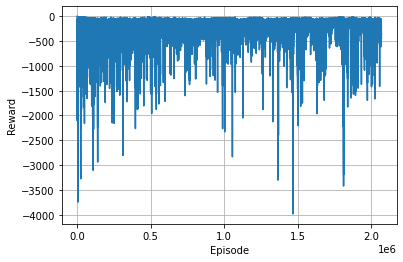

time: 14h 12min 58s (started: 2022-12-17 21:15:49 +00:00)


In [ ]:
import numpy as np
#from utils import plotLearning

env1 = RendezvousEnv()
agent = Agent(alpha=0.0001, beta=0.0001, input_dims=[3], tau=0.001, env=env1,
              batch_size=256,  layer1_size=400, layer2_size=300, n_actions=3)

#agent.load_models()
np.random.seed(0)

score_history = []
obs_state = []
for i in range(2300):
    obs = env1.reset()
    done = False
    score = 0
   # c_loss = 0
    a_loss = 0
    while not done:
        act = agent.choose_action(obs)
        new_state, reward, done, info = env1.step(act)
        agent.remember(obs, act, reward, new_state, int(done))
        agent.learn()


       
       
        score += reward
       
        obs = new_state
        #env1.render()
        score_history.append(score)
        #obs_state.append(obs)
        


        

    
    ## Take the last 100 episodes and take mean for that
    print('episode ', i, 'score %.2f' % score,  
          'Average Reward for 100 episodes %.3f' % np.mean(score_history[-100:]))
    
    ## Saving model for every 25 episodes
    if i % 25 == 0:
          agent.save_models()

filename = 'Results_per_100eps.png'
plotLearning(score_history, filename, window=100)


In [ ]:
#import os
#os.getcwd()

time: 339 µs (started: 2022-12-18 11:28:47 +00:00)


In [ ]:
obs_state[0:][:]

[]

time: 2.31 ms (started: 2022-12-18 11:28:47 +00:00)


time: 7.62 ms (started: 2022-12-18 11:28:47 +00:00)
